In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import random
import pandas as pd

In [2]:
def is_valid(data):
    validity = 1
    for pt in data:
        if pt == 'nan':
            validity = 0
           
    if validity ==1:
        return True
    else:
        return False

# converts str to floats, modify region id
def process_line(data):
    
    for idx in range(len(data)):
        if idx != 1:
            data[idx] = float(data[idx])
        else:
            if data[1] == '0x2000000000000000':
                data[1] = 6e9
            elif data[1] == '0x8000000000000000':
                data[1] = 5e9
            else:
                data[1] = int(data[1], 16)

    return np.asarray(data)


def set_regions(df):
    
    df['region_id'].replace(float(int('0x00000000536c798f', 16)), "sleep", inplace=True)
    df['region_id'].replace(float(int('0x00000000644f9787', 16)), "init", inplace=True)
    df['region_id'].replace(float(int('0x00000000a74bbf35', 16)), "dgemm", inplace=True)
    df['region_id'].replace(float(int('0x00000000d691da00', 16)), "stream", inplace=True)
    df['region_id'].replace(float(6e9), "unmarked", inplace=True)
    df['region_id'].replace(float(5e9), "epoch", inplace=True)
    
    for i in range(df.index[len(df)-1]):
        
        if isinstance(df.at[i,'region_id'],float):
            df['region_id'].replace(df.at[i,'region_id'], "unmarked", inplace=True)
        
    return df


In [3]:
# Interpolate to get metrics which are equally spaced in time 
def interpolate(df):
    t1 = df.at[0,'time']
    t2 = df.at[df.index[len(df)-1], 'time']
    #N = (t2-t1)/0.05
    N = df.index[len(df)-1]
    time_arr = np.linspace(t1, t2, N)
    labels = np.array(['geopm_energy_pkg','geopm_energy_dram','geopm_power_pkg','geopm_power_dram','geopm_cycles_thread','geopm_cycles_reference','geopm_inst-retired'])


    df_interp = pd.DataFrame(columns =labels)
    df_interp['time'] = time_arr
    idx = 0
    for i in range(df_interp.index[len(df_interp)-1]):
        t = df_interp.at[i,'time']
        #find the idx in df
        
        for n in range(idx,df.index[len(df)-1]):
            if df.at[n,'time']<=t and df.at[n+1,'time']>t:
                idx = n
        
        for label in labels:        
            df_interp.at[i,label]=df.at[idx,label]+(df_interp.at[i,'time']-df.at[idx,'time'])*(df.at[idx+1,label]-df.at[idx,label])/(df.at[idx+1,'time']-df.at[idx,'time'])
        
        #if df_interp.at[i,'geopm_frequency']
        if t-df.at[idx,'time']<df.at[idx+1,'time']-t:
            df_interp.at[i,'geopm_frequency'] = df.at[idx,'geopm_frequency']
            df_interp.at[i,'region_id'] = df.at[idx,'region_id']
        else:
            df_interp.at[i,'geopm_frequency'] = df.at[idx+1,'geopm_frequency']
            df_interp.at[i,'region_id'] = df.at[idx+1,'region_id']

    df_interp = df_interp[:-1]
    
    return df_interp


In [4]:
##############   FEATURE GENERATION ####################

# Exponentially weighted moving average
def ewma(df):
    return df.ewm(alpha = 0.5).mean().tail(1)

# sum of absolute difference
def diff_sum(df):
    return (df.shift(-1) - df).abs().sum()

# exponentially weighted gradient
def grad_ewma(df):
    return (df.shift(-1) - df).abs().ewm(alpha = 0.5).mean().tail(1)

# Sample entropy
def SampEn(df):
    U = df.values
    m = 1
    r = 1e-3
    def _maxdist(x_i, x_j):
        result = max([abs(ua - va) for ua, va in zip(x_i, x_j)])
        return result

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C) if sum(C)!=0 else 1

    N = len(U)
    
    return -np.log(_phi(m+1) / _phi(m))


# generate features using a rolling window of size lag
def generate_features(df, lag):

    df_attr = df.rolling(lag, on='time').apply(ewma, raw = False)
    df_attr['feature'] = 'mean_exp_weighted'

    df1 = df.rolling(lag, on='time').std()
    df1['feature'] = 'std'
    df_attr= pd.concat([df_attr,df1])

    df1 = df.rolling(lag, on='time').skew()
    df1['feature'] = 'skew'
    df_attr= pd.concat([df_attr,df1])

    df1 = df.rolling(lag, on='time').kurt()
    df1['feature'] = 'kurtosis'
    df_attr= pd.concat([df_attr,df1])

    df1 = df.rolling(lag, on='time').quantile(0.75)
    df1['feature'] = 'quantile_0.75'
    df_attr= pd.concat([df_attr,df1])

    df1 = df.rolling(lag, on='time').quantile(0.5)
    df1['feature'] = 'quantile_0.5'
    df_attr= pd.concat([df_attr,df1])
    
    df1 = df.rolling(lag, on='time').quantile(0.25)
    df1['feature'] = 'quantile_0.25'
    df_attr= pd.concat([df_attr,df1])

    df1 = df.rolling(lag, on='time').apply(diff_sum, raw = False)
    df1['feature'] = 'diff_sum'
    df_attr= pd.concat([df_attr,df1])

    df1 = df.rolling(lag, on='time').apply(grad_ewma, raw = False)
    df1['feature'] = 'grad_exp_weighted'
    df_attr= pd.concat([df_attr,df1])

    df1 = df.rolling(lag, on='time').apply(SampEn, raw = False)
    df1['feature'] = 'sample_entropy'
    df_attr= pd.concat([df_attr,df1])
    
    return df_attr

In [7]:
## Make a list of the files
file_list = glob.glob("/home/snowcrash/CSEWS18/DI-Lab/data_bench/data_geo/nek*")
#random.shuffle(file_list)
#file_list = random.sample(file_list,1)
#print(file_list)
labels = np.array(['time','region_id','geopm_energy_pkg','geopm_energy_dram','geopm_power_pkg','geopm_power_dram',
                   'geopm_frequency','geopm_cycles_thread','geopm_cycles_reference','geopm_inst-retired',
                   'time_diff'])


labels1 = np.array(['time','geopm_energy_pkg','geopm_energy_dram','geopm_power_pkg','geopm_power_dram',
                   'geopm_frequency','geopm_cycles_thread','geopm_cycles_reference','geopm_inst-retired'])

labels2 = np.array(['geopm_energy_pkg','geopm_energy_dram','geopm_power_pkg','geopm_power_dram',
                   'geopm_frequency','geopm_cycles_thread','geopm_cycles_reference','geopm_inst-retired'])
lags = 9

## Read data from each file in the file list and store features
first_stack = True
for i in range(len(file_list)):
    line1= []
    line2 = []       
    line_no = 0
    isfirst = True
    filename = file_list[i]
    row = []
    data = []
    with open(file_list[i]) as f:
        print(f)
        for _ in range(1):
            next(f)
        for rows in f:
            
            row1 = rows.split(',')
            row = process_line(row1)
            
            if isfirst:
                isfirst = False
                data = row
            else:
                data = np.vstack([data, row])
                    
    if first_stack:
        df = pd.DataFrame(data, columns =labels)
        df.drop_duplicates('time', keep='first', inplace =True)
        df = df.reset_index(drop=True)
        
        df = interpolate(df)

        i=0
        while i<df.index[len(df)-3]:
        
            if df.at[i,'geopm_frequency'] != df.at[i+2,'geopm_frequency']:

                #if df.at[i,'geopm_frequency'] == df.at[i+1,'geopm_frequency']:
                df.at[i+2,'geopm_frequency'] = df.at[i,'geopm_frequency']
                #else:
                 #   df.at[i,'geopm_frequency'] = df.at[i+2,'geopm_frequency'] 
            
            i+=3
        
        print('Interpolation complete')

        label = np.array(['time','geopm_energy_pkg','geopm_energy_dram','geopm_power_pkg',
                          'geopm_power_dram','geopm_frequency','geopm_inst-retired'])
        df_out = df.filter(label, axis=1)
        df_out = df_out.shift(-9)
        df_out = df_out.rolling(3,on='time').mean()
        df_out = df_out.shift(-2)
        df_out['time'] = df['time'].shift(-8)
        
        df_reg = df['region_id'].rolling(lags).median().shift(-8)
        
        df_out = pd.concat([df_out, df_reg], axis=1)
        df_out = df_out.dropna()
        df_out = set_regions(df_out)
        df_out = df_out.set_index('time')
        len_df = df.index[len(df)-1]
        df.drop([len_df,len_df-1,len_df-2], inplace = True)
        
        df1 = df.filter(labels1, axis=1)
        df1 = generate_features(df1, lags).dropna()
        print('Feature generation complete')
        
        for label in labels2:
            if label ==labels2[0]:
                df_1 = df1.pivot(index='time', columns='feature', values=label)
                df_1.columns = [label+'_'+s  for s in df_1.columns]
            else:
                df_2 = df1.pivot(index='time', columns='feature', values=label)
                df_2.columns = [label+'_'+s  for s in df_2.columns]
                df_1 = pd.concat([df_1, df_2], axis=1)
        df1 = df_1
        
        df = pd.concat([df1, df_out], axis=1)
        df = df.iloc[::3]         
        df.to_csv('/home/snowcrash/CSEWS18/DI-Lab/data_bench/data_geo/features/'+filename[51:],sep='|', na_rep = 'nan')
        

<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/data_bench/data_geo/nekbone_trace_Wed May  8 01:05:34 CEST 2019-mpp3r03c04s07' mode='r' encoding='UTF-8'>
Interpolation complete
Feature generation complete
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/data_bench/data_geo/nekbone_trace_Wed May  8 01:23:36 CEST 2019-mpp3r03c04s07' mode='r' encoding='UTF-8'>
Interpolation complete
Feature generation complete
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/data_bench/data_geo/nekbone_trace_Wed May  8 01:14:34 CEST 2019-mpp3r03c04s07' mode='r' encoding='UTF-8'>
Interpolation complete
Feature generation complete
<_io.TextIOWrapper name='/home/snowcrash/CSEWS18/DI-Lab/data_bench/data_geo/nekbone_trace_Wed May  8 01:41:34 CEST 2019-mpp3r03c04s07' mode='r' encoding='UTF-8'>
Interpolation complete
Feature generation complete


In [6]:
df.to_csv('/home/snowcrash/CSEWS18/DI-Lab/data_bench/data_geo/features/'+filename[51:],sep='|', na_rep = 'nan')

In [49]:
df.to_csv('/home/snowcrash/CSEWS18/DI-Lab/data_bench/data_pre/features/kripke_trace_Sun Apr  7 02:26:35 CEST 2019-mpp3r03c05s04',sep='|', na_rep = 'nan')

In [34]:
df

,geopm_energy_pkg,geopm_energy_dram,geopm_power_pkg,geopm_power_dram,geopm_cycles_thread,geopm_cycles_reference,geopm_inst-retired,time,geopm_frequency,region_id
0,5.2608,0.593079,86.9545,9.76956,5.09206e+08,2.71074e+08,1.36891e+08,1.992471,1.100000e+09,1.682938e+09
1,3.29338,0.375433,83.7681,9.4844,2.96104e+08,1.93882e+08,5.97295e+07,2.042626,1.100000e+09,1.682938e+09
2,4.1762,0.515334,81.8022,9.51197,3.90856e+08,2.48905e+08,9.07636e+07,2.092780,1.100000e+09,1.682938e+09
3,5.03262,0.702061,80.1377,9.79925,6.17432e+08,3.94284e+08,1.22954e+08,2.142935,1.200000e+09,1.682938e+09
4,3.60426,0.57892,82.8235,10.2554,7.70825e+08,3.52612e+08,1.95805e+08,2.193090,1.200000e+09,1.682938e+09
5,5.76969,1.39525,93.4236,12.0343,2.54582e+09,1.06907e+09,7.61757e+08,2.243245,1.200000e+09,1.682938e+09
6,6.94636,1.70318,110.489,14.7532,3.45657e+09,1.44503e+09,1.20164e+09,2.293400,1.300000e+09,1.682938e+09
7,6.56923,1.69517,128.203,19.538,3.79901e+09,1.39128e+09,1.27271e+09,2.343555,1.300000e+09,1.682938e+09
8,7.48921,1.71237,139.949,23.8568,4.34232e+09,1.60857e+09,1.48878e+09,2.393710,1.300000e+09,1.682938e+09
9,7.8409,1.7992,144.95,27.8844,4.59006e+09,1.70145e+09,1.51263e+09,2.443865,1.100000e+09,1.682938e+09


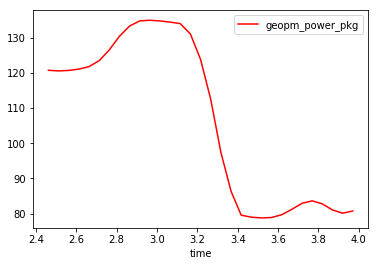

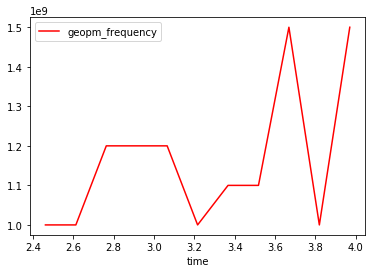

In [19]:
df_out = df_out[df_out['time']<4]
df_out.plot(kind='line',x='time',y='geopm_power_pkg',color='red')
df_out.plot(kind='line',x='time',y='geopm_frequency',color='red')

In [66]:
df.sort_values(by='geopm_power_pkg', axis=0)

,geopm_energy_pkg,geopm_energy_dram,geopm_power_pkg,geopm_power_dram,geopm_cycles_thread,geopm_cycles_reference,geopm_inst-retired,time,geopm_frequency,region_id
259,3.32836,0.409012,78.0912,9.62427,3.19342e+08,2.19106e+08,6.90374e+07,15.254329,1.000000e+09,1.399618e+09
399,4.35048,0.535888,78.115,9.56509,3.76106e+08,3.14793e+08,1.0205e+08,22.286062,1.000000e+09,1.399618e+09
50,3.08843,0.368574,78.1938,9.58915,2.72454e+08,2.27662e+08,6.58746e+07,4.756955,1.000000e+09,1.399618e+09
51,4.1238,0.49848,78.2906,9.58482,3.47478e+08,2.91462e+08,1.04579e+08,4.807181,1.000000e+09,1.399618e+09
160,4.14031,0.500522,78.2969,9.49845,4.19237e+08,4.15727e+08,1.46214e+08,10.281888,1.100000e+09,1.399618e+09
258,4.55675,0.55731,78.3232,9.67501,4.46631e+08,2.96949e+08,9.79198e+07,15.204102,1.000000e+09,1.399618e+09
363,4.71908,0.57301,78.3466,9.46306,4.24618e+08,3.30972e+08,1.36978e+08,20.477902,1.200000e+09,1.399618e+09
260,3.78322,0.465371,78.3546,9.61536,3.64802e+08,2.43106e+08,7.6218e+07,15.304555,1.000000e+09,1.399618e+09
243,4.56267,0.558345,78.4372,9.47091,3.71765e+08,2.6605e+08,8.76526e+07,14.450702,1.000000e+09,1.399618e+09
261,4.54454,0.550649,78.457,9.61422,4.51031e+08,2.93609e+08,9.71189e+07,15.354782,1.200000e+09,1.399618e+09


In [18]:
df[df['time']<8]

,geopm_energy_pkg,geopm_energy_dram,geopm_power_pkg,geopm_power_dram,geopm_cycles_thread,geopm_cycles_reference,geopm_inst-retired,time,geopm_frequency,region_id
0,0.348145,0.0388184,91.8444,9.20886,6.04173e+07,3.83043e+07,1.85647e+07,1.866621,1.500000e+09,1.682938e+09
1,4.41931,0.488613,87.4,9.45525,5.11775e+08,2.35767e+08,1.04345e+08,1.917009,1.300000e+09,1.682938e+09
2,3.38517,0.521424,85.9445,10.5608,5.85769e+08,2.9324e+08,1.48473e+08,1.967398,1.300000e+09,1.682938e+09
3,5.51537,1.45343,93.4372,14.984,2.22753e+09,8.83847e+08,4.18745e+08,2.017787,1.300000e+09,1.682938e+09
4,7.60149,2.1353,112.433,19.7397,4.52659e+09,1.71364e+09,8.13532e+08,2.068175,1.100000e+09,1.682938e+09
5,5.57067,1.6208,127.056,23.6008,3.11691e+09,1.32764e+09,5.7364e+08,2.118564,1.100000e+09,1.682938e+09
6,6.2254,2.31477,130.065,27.9268,3.5975e+09,1.5767e+09,6.73307e+08,2.168952,1.100000e+09,1.682938e+09
7,7.27047,3.70125,126.719,33.9466,4.05536e+09,1.7569e+09,7.48054e+08,2.219341,1.000000e+09,1.682938e+09
8,5.14928,2.74617,124.73,43.4162,2.80724e+09,1.39144e+09,5.34537e+08,2.269730,1.000000e+09,1.682938e+09
9,6.10446,3.26632,123.05,50.1131,3.27857e+09,1.55425e+09,6.17694e+08,2.320118,1.000000e+09,1.682938e+09


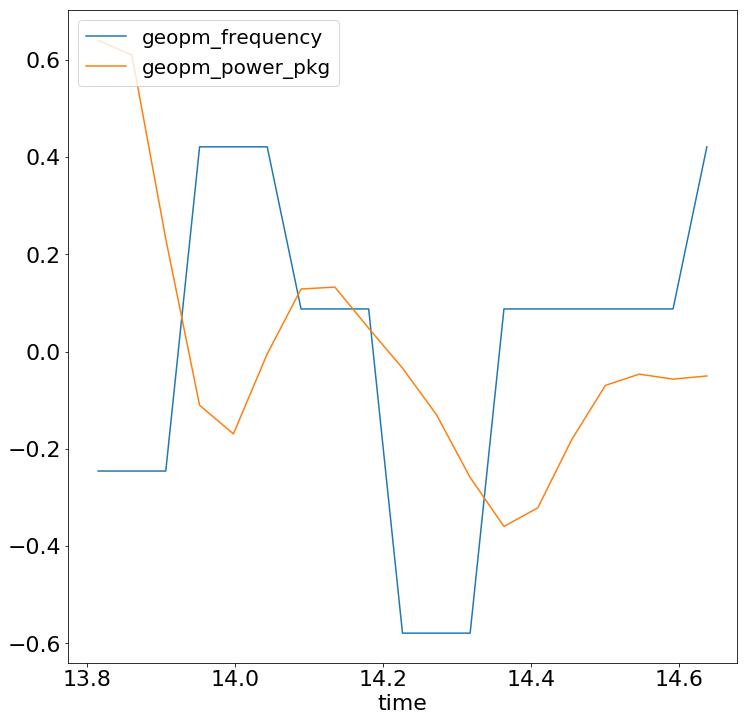

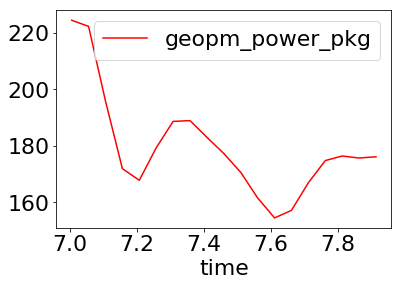

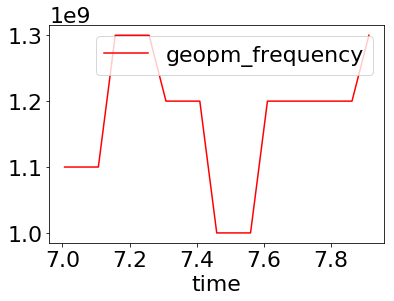

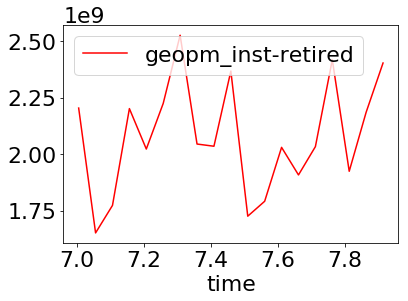

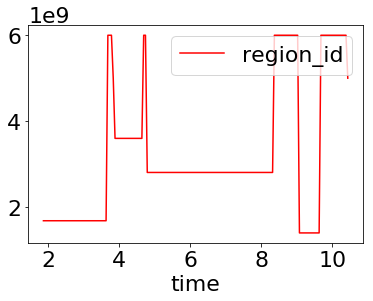

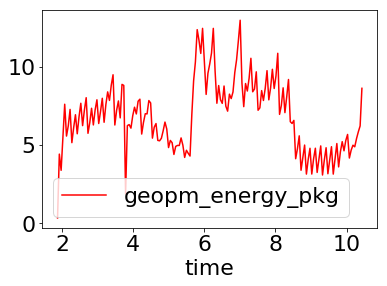

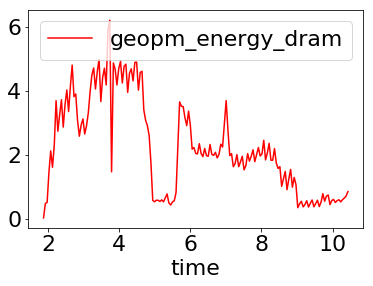

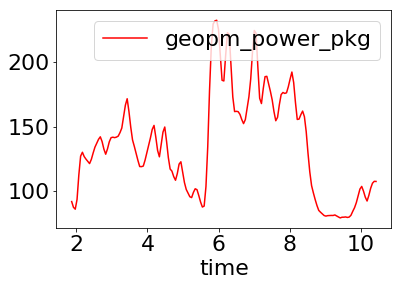

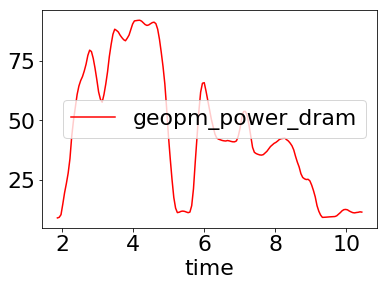

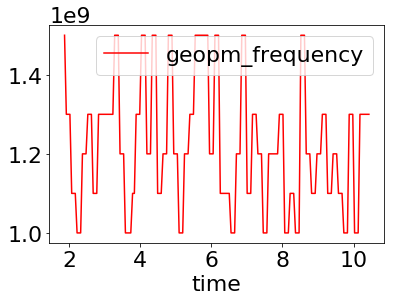

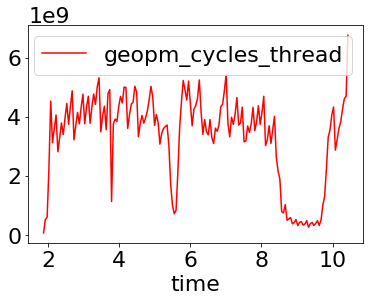

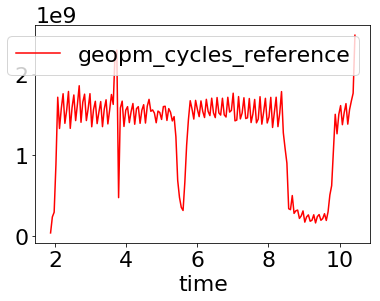

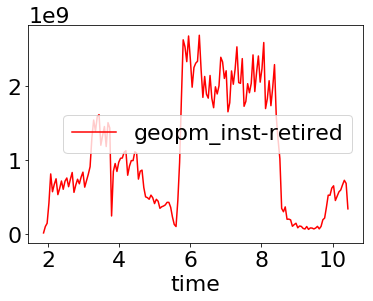

In [31]:
labels = np.array(['region_id','geopm_energy_pkg','geopm_energy_dram','geopm_power_pkg','geopm_power_dram',
                   'geopm_frequency','geopm_cycles_thread','geopm_cycles_reference','geopm_inst-retired'])
df1 = df.iloc[102:121]
df2 = (df1 - df1.mean()) / (df1.max() - df1.min())
df2['time'] = df1['time']*((df1['time'].max() - df1['time'].min())) +df1['time'].mean()
matplotlib.rcParams.update({'font.size': 22})
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.plot(df2['time'], df2['geopm_frequency'])
plt.xlabel('time')
#plt.ylabel('frequency')
#plt.plot(df2['time'], df2['geopm_inst-retired'])

plt.xlabel('time')
#plt.ylabel('inst-retired')
plt.plot(df2['time'], df2['geopm_power_pkg'])
plt.xlabel('time')
#plt.ylabel('energy pkg')
plt.legend(loc=2, prop={'size': 20})
plt.show()
fig.savefig('freq-power_correlation', dpi=100)
df1.plot(kind='line',x='time',y='geopm_power_pkg',color='red')
df1.plot(kind='line',x='time',y='geopm_frequency',color='red')
df1.plot(kind='line',x='time',y='geopm_inst-retired',color='red')
for label in labels:
    df.plot(kind='line',x='time',y=label,color='red')
    plt.show()

In [74]:
'''        
        first_stack = False

    else:
        df1 = pd.DataFrame(data, columns =labels)
        df1.drop_duplicates('time', keep='first', inplace =True)
        df1 = df1.reset_index(drop=True)
        df1 = interpolate(df1)
        df1['energy_dram'] =   df1['energy_dram'].shift(-1)-df1['energy_dram']
        df1['energy_pkg'] =    df1['energy_pkg'].shift(-1)-df1['energy_pkg']
        df1['cycles_thread'] = df1['cycles_thread'].shift(-1)-df1['cycles_thread']
        df1['inst-retired'] =  df1['inst-retired'].shift(-1)-df1['inst-retired']
        
        df1 = generate_features(df1, lags)
        
        
        df= pd.concat([df,df1])
        print(df.shape)
        line_no +=1
'''

,time,energy_pkg,energy_dram,power_pkg,power_dram,frequency,cycles_thread,inst-retired
0,2.196582,5.90399,2.40601,123.547,52.9441,1e+09,3.20627e+09,5.96311e+08
1,2.246819,6.08562,2.53624,119.851,50.1918,1.1e+09,3.25505e+09,6.01245e+08
2,2.297055,6.33409,2.61987,122.46,48.956,1e+09,3.50499e+09,6.45119e+08
3,2.347292,6.08817,2.54573,124.054,49.9736,1.1e+09,3.27054e+09,6.02159e+08
4,2.397529,6.34179,2.64615,124.739,50.3364,1e+09,3.52337e+09,6.57023e+08
5,2.447765,6.02447,2.86465,123.674,51.4283,1.1e+09,3.26485e+09,6.0801e+08
6,2.498002,6.40645,3.38919,125.135,53.7471,1e+09,3.56704e+09,6.6737e+08
7,2.548238,6.14005,3.4312,124.25,56.6121,1e+09,3.29868e+09,6.14632e+08
8,2.598475,6.04984,3.37141,123.56,59.6336,1.1e+09,3.30445e+09,6.15586e+08
9,2.648712,6.43999,3.98537,123.965,63.5954,1.1e+09,3.58917e+09,6.64825e+08


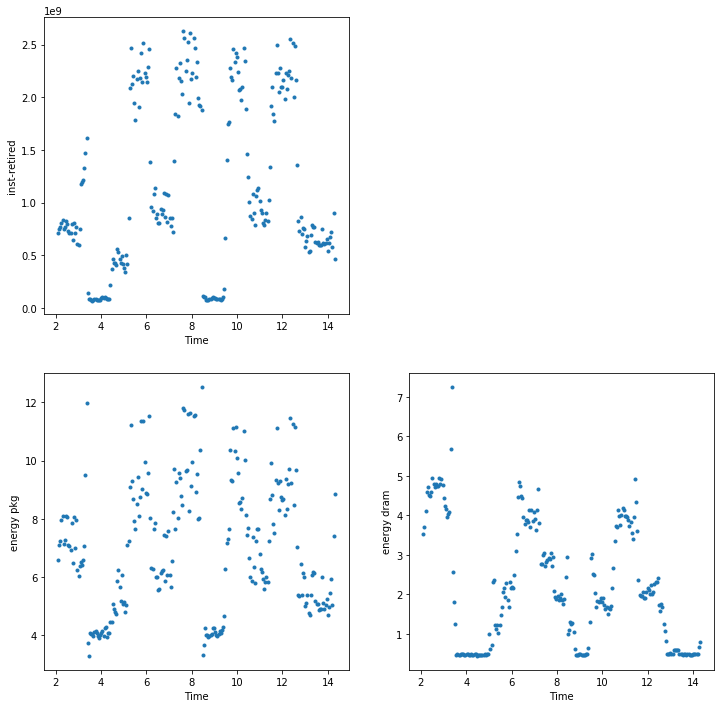

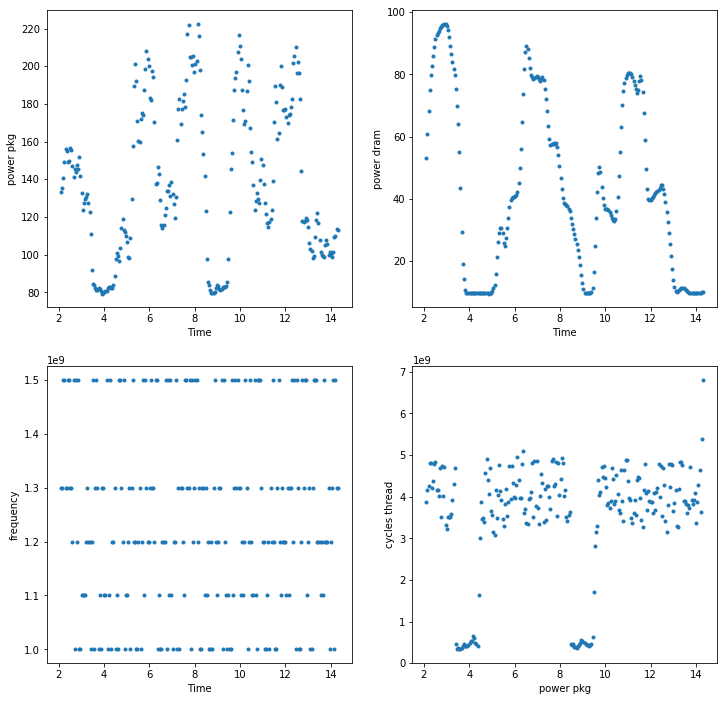

In [59]:
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.subplot(2,2,1)
plt.plot(df['time'], df['inst-retired'],'.')
plt.xlabel('Time')
plt.ylabel('inst-retired')
plt.subplot(2,2,3)
plt.plot(df['time'], df['energy_pkg'],'.')
plt.xlabel('Time')
plt.ylabel('energy pkg')
plt.subplot(2,2,4)
plt.plot(df['time'], df['energy_dram'],'.')
plt.xlabel('Time')
plt.ylabel('energy dram')
fig.savefig('twopower_runs_1', dpi=100)
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.subplot(2,2,1)
plt.plot(df['time'], df['power_pkg'],'.')
plt.xlabel('Time')
plt.ylabel('power pkg')
plt.subplot(2,2,2)
plt.plot(df['time'], df['power_dram'],'.')
plt.xlabel('Time')
plt.ylabel('power dram')
plt.subplot(2,2,3)
plt.plot(df['time'], df['frequency'],'.')
plt.xlabel('Time')
plt.ylabel('frequency')
plt.subplot(2,2,4)
plt.plot(df['time'], df['cycles_thread'],'.')
plt.xlabel('power pkg')
plt.ylabel('cycles thread')
fig.savefig('twopower_runs_2', dpi=100)
plt.show()